In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Libraries and Datasets

In [ ]:
# Data preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from google.colab import files

# Modelling
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, f1_score, precision_recall_fscore_support

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.read_csv('synexchangedata.csv') # location of exchange data csv file

## Data Preprocessing

In [ ]:
data.head()

,domain,trust_score,blacklisted,ip_bad_count_bad,ssl_valid,ip_country,anonymous_whois,dnsblock_threat_count,whois_registration_duration,whois_valid_email,avg_review_score,facebook_comments_negative_count,facebook_comments_positive_count,scamadviser_votes_legit,scamadviser_votes_scam,scamadviser_votes_fake,is_legit
0,merlinswap.org,56.0,0,0.29,1,US,1,0,0.53,0,0.00,0.0,0.0,0,0,0,1
1,fatbtc.com,1.0,0,0.03,1,US,1,0,10.51,0,1.49,0.0,0.0,0,0,0,1
2,camelot.exchange,12.0,0,0.26,1,US,1,0,1.82,0,0.00,0.0,0.0,0,0,0,1
3,fast.exchange.onetrading.com,80.0,0,0.00,1,US,1,0,20.05,1,0.00,0.0,0.0,0,0,0,1
4,dackieswap.xyz,1.0,0,0.41,1,US,1,0,1.28,0,1.00,0.0,0.0,0,0,0,1


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1084 entries, 0 to 1083
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   domain                            1064 non-null   object 
 1   trust_score                       1084 non-null   float64
 2   blacklisted                       1084 non-null   int64  
 3   ip_bad_count_bad                  1084 non-null   float64
 4   ssl_valid                         1084 non-null   int64  
 5   ip_country                        1084 non-null   object 
 6   anonymous_whois                   1084 non-null   int64  
 7   dnsblock_threat_count             1084 non-null   int64  
 8   whois_registration_duration       1084 non-null   float64
 9   whois_valid_email                 1084 non-null   int64  
 10  avg_review_score                  1084 non-null   float64
 11  facebook_comments_negative_count  1084 non-null   float64
 12  facebo

In [ ]:
data.isnull().sum()

domain                              20
trust_score                          0
blacklisted                          0
ip_bad_count_bad                     0
ssl_valid                            0
ip_country                           0
anonymous_whois                      0
dnsblock_threat_count                0
whois_registration_duration          0
whois_valid_email                    0
avg_review_score                     0
facebook_comments_negative_count     0
facebook_comments_positive_count     0
scamadviser_votes_legit              0
scamadviser_votes_scam               0
scamadviser_votes_fake               0
is_legit                             0
dtype: int64

In [ ]:
# drop domain name
data.drop('domain', axis=1, inplace=True)

### Feature engineering
- Converting categorical data
- Scaling and nomalising


In [ ]:
encoder = OneHotEncoder(sparse=False)
encoded_data = encoder.fit_transform(data[['ip_country']])

# convert encoded data to dataframe
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['ip_country']))
e_data = pd.concat([data, encoded_df], axis=1)
e_data.drop('ip_country', axis=1, inplace=True)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# Scaling numerical features
scaler = StandardScaler()
numerical = ['trust_score', 'ip_bad_count_bad', 'dnsblock_threat_count', 'whois_registration_duration', 'avg_review_score',
             'facebook_comments_negative_count', 'facebook_comments_positive_count', 'scamadviser_votes_legit', 'scamadviser_votes_scam',
             'scamadviser_votes_fake']
scaler.fit_transform(e_data[numerical])

array([[ 0.31729603,  0.47005701, -0.28159548, ..., -0.22367834,
        -0.22878307, -0.22103199],
       [-1.1499027 , -0.62139849, -0.28159548, ..., -0.22367834,
        -0.22878307, -0.22103199],
       [-0.85646295,  0.34411984, -0.28159548, ..., -0.22367834,
        -0.22878307, -0.22103199],
       ...,
       [-0.4296415 , -0.74733566, -0.28159548, ..., -0.22367834,
        -0.22878307, -0.22103199],
       [ 1.49105501, -0.57941943, -0.28159548, ...,  4.80676409,
         5.77633513,  5.69802945],
       [-0.82978661,  0.3860989 , -0.28159548, ..., -0.22367834,
        -0.22878307, -0.22103199]])

## Model params and tuning

In [ ]:
# Splitting into features (X) and target (y)
X = e_data.drop('is_legit', axis=1)
y = e_data['is_legit']

In [ ]:
# defining params
params = {
    'n_neighbors': [3,5,7,9,11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# initialise model
knn = KNeighborsClassifier()

# initialise gridsearch
grid_search = GridSearchCV(estimator=knn, param_grid=params, cv=10, scoring='accuracy', n_jobs=-1)

In [ ]:
from sklearn.base import clone

# Performing grid search
grid_search.fit(X, y)


GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [3, 5, 7, 9, 11],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [ ]:

# Retrieving best model
best_knn = grid_search.best_estimator_
knn2 = clone(best_knn)

# Retrieving best params
best_params = grid_search.best_params_
print(best_params)

{'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}


# Train & evaluate model

In [ ]:
# define 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True)

## Experiment with all features

In [ ]:
# Evaluating model perfomance using k-fold cross validation to test the performance
y_pred_all = cross_val_predict(best_knn, X, y, cv=kf, method='predict')
y_pred_proba_all = cross_val_predict(best_knn, X, y, cv=kf, method='predict_proba')[:, 1]

accuracy_scores = cross_val_score(best_knn, X, y, cv=kf, scoring='accuracy')
precision_scores = cross_val_score(best_knn, X, y, cv=kf, scoring='precision')
recall_scores = cross_val_score(best_knn, X, y, cv=kf, scoring='recall')
f1_scores = cross_val_score(best_knn, X, y, cv=kf, scoring='f1')


# Print average metrics
print("Avg accuracy: ", np.mean(accuracy_scores), "s.d: ", np.std(accuracy_scores))
print("Avg precision: ", np.mean(precision_scores), "s.d: ", np.std(precision_scores))
print("Avg recall: ", np.mean(recall_scores), "s.d: ", np.std(recall_scores))
print("Avg f1: ", np.mean(f1_scores), "s.d: ", np.std(f1_scores))

Avg accuracy:  0.9446398233095481 s.d:  0.025815438488622732
Avg precision:  0.9512645811188631 s.d:  0.04050093839000594
Avg recall:  0.9288170637221999 s.d:  0.03728660528516821
Avg f1:  0.9329433261096494 s.d:  0.03087515354853756


## Experiment with selected features

In [ ]:
# Select features
features = ['whois_registration_duration',
                     'trust_score',
                     'avg_review_score',
                     'ip_bad_count_bad',
                      'scamadviser_votes_scam',
                      'ssl_valid',
                     'whois_valid_email',
                     'scamadviser_votes_legit',
                      'facebook_comments_negative_count',
                      'anonymous_whois',
                      'dnsblock_threat_count',
                     'scamadviser_votes_fake' ]

# selecting important features only
selected_X = X[features]

In [ ]:
# Evaluating model perfomance using k-fold cross validation to test the performance
y_pred_important = cross_val_predict(knn2, selected_X, y, cv=kf, method='predict')
y_pred_proba_important = cross_val_predict(knn2, selected_X, y, cv=kf, method='predict_proba')[:, 1]

sel_accuracy_scores = cross_val_score(knn2, selected_X, y, cv=kf, scoring='accuracy')
sel_precision_scores = cross_val_score(knn2, selected_X, y, cv=kf, scoring='precision')
sel_recall_scores = cross_val_score(knn2, selected_X, y, cv=kf, scoring='recall')
sel_f1_scores = cross_val_score(knn2, selected_X, y, cv=kf, scoring='f1')


# Print average metrics
print("Avg accuracy: ", np.mean(sel_accuracy_scores), "s.d: ", np.std(sel_accuracy_scores))
print("Avg precision: ", np.mean(sel_precision_scores), "s.d: ", np.std(sel_precision_scores))
print("Avg recall: ", np.mean(sel_recall_scores), "s.d: ", np.std(sel_recall_scores))
print("Avg f1: ", np.mean(sel_f1_scores), "s.d: ", np.std(sel_f1_scores))

Avg accuracy:  0.9482755691471288 s.d:  0.01999713076513618
Avg precision:  0.9476277977341807 s.d:  0.03765800374743558
Avg recall:  0.9180873676710058 s.d:  0.031079711643703115
Avg f1:  0.938917226807507 s.d:  0.022994149130231185


In [ ]:
# Compare the results
print(f"Improvement in accuracy: {sel_accuracy_scores.mean() - accuracy_scores.mean():.4f}")
print(f"Improvement in precision: {sel_precision_scores.mean() - precision_scores.mean():.4f}")
print(f"Improvement in recall: {sel_recall_scores.mean() - recall_scores.mean():.4f}")
print(f"Improvement in F1-score: {sel_f1_scores.mean() - f1_scores.mean():.4f}")

Improvement in accuracy: 0.0036
Improvement in precision: -0.0036
Improvement in recall: -0.0107
Improvement in F1-score: 0.0060


In [ ]:
from scipy import stats

def test(score1, score2):
  # Perform paired t-test
  t_stat, p_value = stats.ttest_rel(score1, score2)

  print(f'Paired t-test statistic: {t_stat:.4f}')
  print(f'P-value: {p_value:.4f}')

  if p_value < 0.05:
      print("The difference between the models with all features and selected features is statistically significant.")
  else:
      print("The difference between the models with all features and selected features is not statistically significant.")

In [ ]:
print("Accuracy - ", end = " ")
test(accuracy_scores, sel_accuracy_scores)

print("Precision - ", end = " ")
test(precision_scores, sel_precision_scores)

print("Recall - ", end = " ")
test(recall_scores, sel_recall_scores)

print("F1 score - ", end = " ")
test(f1_scores, sel_f1_scores)

Accuracy -  Paired t-test statistic: -0.2866
P-value: 0.7809
The difference between the models with all features and selected features is not statistically significant.
Precision -  Paired t-test statistic: 0.2070
P-value: 0.8406
The difference between the models with all features and selected features is not statistically significant.
Recall -  Paired t-test statistic: 0.6396
P-value: 0.5383
The difference between the models with all features and selected features is not statistically significant.
F1 score -  Paired t-test statistic: -0.5979
P-value: 0.5647
The difference between the models with all features and selected features is not statistically significant.


In [ ]:
# roc function

def plot_roc_curve(y_true, y_scores, title):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

    data_filename = title+'.csv'
    # Save the ROC curve data
    roc_data = pd.DataFrame({'fpr': fpr, 'tpr': tpr, })
    roc_data.to_csv(data_filename, index=False)

    # Download the files to local machine
    files.download(data_filename)


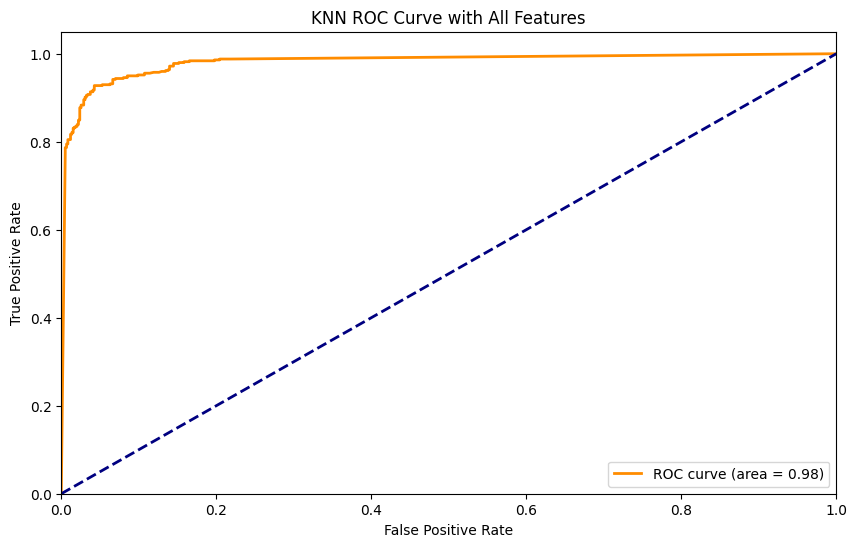

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

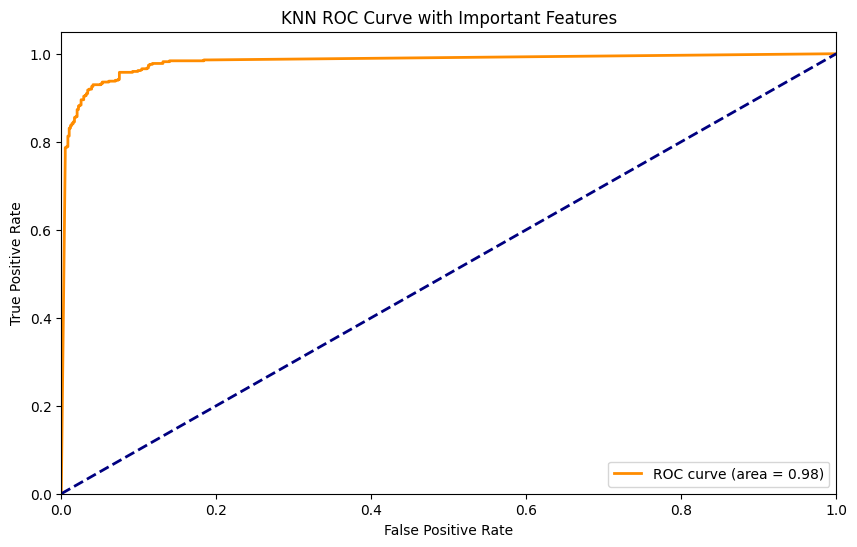

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ROC curve for all features
plot_roc_curve(y, y_pred_proba_all, 'KNN ROC Curve with All Features')

# ROC curve for important features
plot_roc_curve(y, y_pred_proba_important, 'KNN ROC Curve with Important Features')